In [1]:
import cv2
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import pandas as pd
from PIL import Image
from sklearn.metrics import classification_report, f1_score, confusion_matrix


In [2]:
# Génération de données d'entraînement avec augmentation

datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [3]:
# Callbacks 
 
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True),
    ModelCheckpoint(filepath='models/oliwer.keras', save_best_only=True),
]

In [4]:
def generate_batch(image):
    train_data = []
    train_labels = []
    image_normalized = image.astype('float32') / 255.0
    image_reshaped = np.expand_dims(image_normalized, axis=-1)
    image_batch = np.expand_dims(image_reshaped, axis=0)
    
    # Générer 10 images augmentées par image originale
    augmented_count = 0
    for batch in datagen.flow(image_batch, batch_size=1):
        if augmented_count >= 10:  # Limiter à 10 images augmentées par image
            break
        
        augmented_image = batch[0]
        augmented_image = (augmented_image.squeeze() * 255).astype('uint8')
        
        train_data.append(augmented_image)
        train_labels.append(1)
        augmented_count += 1

    return train_data, train_labels


In [5]:
# Charger les données d'entraienement 

def load_data():
    # Initialiser les listes pour les données et les labels
    train_data = []
    train_labels = []
    test_data = []
    test_labels = []

    # Données oliwer
    for photos in ['oliwer']:
        train = f'processed/{photos}/train/' # Images d'entraînement

        for file in os.listdir(train):
            if file.endswith('.jpg') or file.endswith('.png'):
                img = os.path.join(train, file) # Lire le chemin de l'image
                image = cv2.imread(img, cv2.IMREAD_GRAYSCALE) # Transformer l'image en gris
                image = cv2.resize(image, (64, 64)) # Redimensionner l'image à 64x64 pixels
                
                # Ajouter l'image originale
                train_data.append(image)
                train_labels.append(1) # 1 = Oliwer
                
                # Générer des images augmentées
                # augmented_data, augmented_labels = generate_batch(image)
                # train_data.extend(augmented_data)
                # train_labels.extend(augmented_labels)

        for file in os.listdir(f'processed/{photos}/test/'):
            if file.endswith('.jpg') or file.endswith('.png'):
                img = os.path.join(f'processed/{photos}/test/', file) # Lire le chemin de l'image de test
                image = cv2.imread(img, cv2.IMREAD_GRAYSCALE) # Transformer l'image en gris
                image = cv2.resize(image, (64, 64)) # Redimensionner l'image à 64x64 pixels
                test_data.append(image) # Ajouter l'image à la liste des données de test
                test_labels.append(1) # Ajouter le label correspondant

    # Données aléatoires depuis ./binary_dataset/others
    others_dir = './binary_dataset/others'
    others_files = [f for f in os.listdir(others_dir) if f.endswith('.jpg') or f.endswith('.png')]
    np.random.shuffle(others_files)
    split_idx = int(0.8 * len(others_files))
    train_others = others_files[:split_idx]
    test_others = others_files[split_idx:]

    # Ajout aux données d'entraînement (label 0)
    for file in train_others:
        img = os.path.join(others_dir, file)
        image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64))
        train_data.append(image)
        train_labels.append(0)

    # Ajout aux données de test (label 0)
    for file in test_others:
        img = os.path.join(others_dir, file)
        image = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (64, 64))
        test_data.append(image)
        test_labels.append(0)

    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)

In [6]:
# Préparation des données 

train_data, train_labels, test_data, test_labels = load_data() # Charger les données

# Afficher le nombre d'échantillons dans chaque ensemble
print(f"Nombre d'images d'entraînement: {len(train_data)}")
print(f"Nombre de labels d'entraînement: {len(train_labels)}") 
print(f"Nombre d'images de test: {len(test_data)}")
print(f"Nombre de labels de test: {len(test_labels)}")

# Vérifier la cohérence des tailles
assert len(train_data) == len(train_labels), "Incohérence entre données et labels d'entraînement"
assert len(test_data) == len(test_labels), "Incohérence entre données et labels de test"

# Normalisation des données
train_data = train_data.astype('float32') / 255.0
test_data = test_data.astype('float32') / 255.0

# Transformer les images en échelle de gris
train_data = np.expand_dims(train_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)


Nombre d'images d'entraînement: 8551
Nombre de labels d'entraînement: 8551
Nombre d'images de test: 2147
Nombre de labels de test: 2147


In [7]:
# Modèle

model = Sequential(
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Dropout(0.4),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 


c:\Users\Oliwer\Documents\facial_recognition\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Décrire le modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 682,753 (2.60 MB)

 Trainable params: 682,753 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Entraîner le modèle

history = model.fit(
    train_data, 
    train_labels,
    validation_data=(test_data, test_labels),
    epochs=10,
    batch_size=32,
    callbacks=callbacks
)

model.save('models/oliwer.keras')

Epoch 1/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9573 - loss: 0.1115 - val_accuracy: 0.9898 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 2/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9875 - loss: 0.0354 - val_accuracy: 0.9907 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 3/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9912 - loss: 0.0259 - val_accuracy: 0.9921 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 4/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9933 - loss: 0.0203 - val_accuracy: 0.9981 - val_loss: 0.0105 - learning_rate: 0.0010
Epoch 5/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9959 - loss: 0.0100 - val_accuracy: 0.9972 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 6/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9972 - loss: 0.0099 - val_accuracy: 0.9977 - val_loss: 0.0074 - learning_rate: 0.0010
Epoch 7/10
268/268 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9968 - loss: 0.

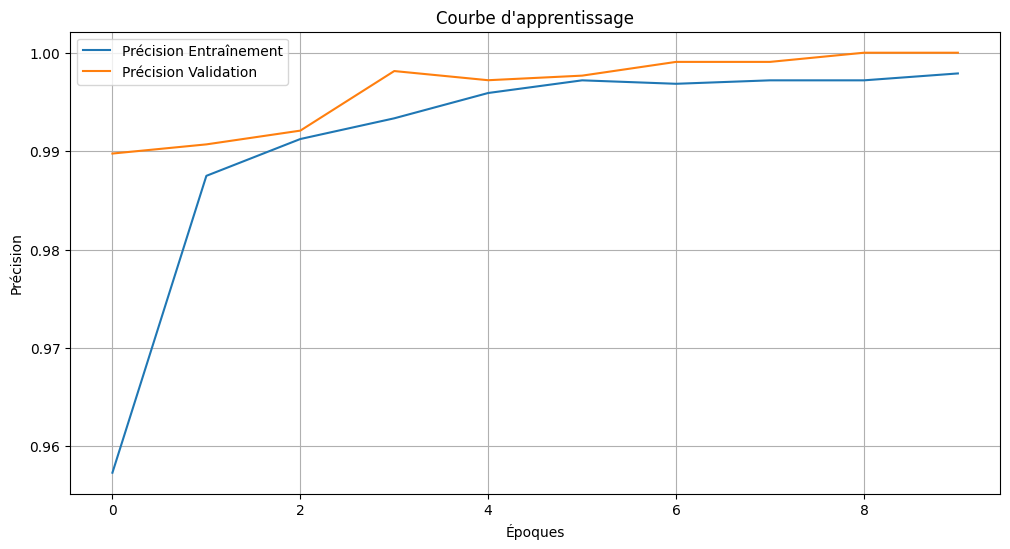

In [10]:
# Courbe apprentissage
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Précision Entraînement')
plt.plot(history.history['val_accuracy'], label='Précision Validation') 
plt.title('Courbe d\'apprentissage')
plt.xlabel('Époques')
plt.ylabel('Précision')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Évaluation du modèle

val = model.evaluate(test_data, test_labels)

load_model = keras.models.load_model('./models/oliwer.keras')
evaluation = load_model.evaluate(test_data, test_labels)

image = cv2.imread('./processed/test_photos/image.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (64, 64))

image = image.astype('float32') / 255.0
image = np.expand_dims(image, axis=-1)  
image = np.expand_dims(image, axis=0)   

prediction = load_model.predict(image)
confidence = prediction[0][0]

if confidence > 0.5:
    print(f"C'est Oliwer avec {confidence:.2%} de confiance")
else:
    print(f"Ce n'est pas Oliwer avec {(1-confidence):.2%} de confiance")

14/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0019 

68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5846e-04
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 5.5846e-04
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
C'est Oliwer avec 80.03% de confiance
